In [2]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import numpy as np
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F


Step 1: Define transform classes, instantiating transform objects and instantiating the dataset.

In [3]:
class CustomToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

In [4]:
class ScalingToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""

    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
transform1 = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()]) ## composes multiple transforms into single one

transform2 = transforms.Compose([transforms.Grayscale(),
                                ScalingToTensor()])

dataset1 = ImageFolder(root='/content/drive/My Drive/categorized_products',
                                       transform=transform1)

dataset2 = ImageFolder(root='/content/drive/My Drive/categorized_products',
                                       transform=transform2)


Step 2: Split Dataset and Make it Iterable

In [7]:
batch_size = 64
validation_split = 0.2
classes1 = dataset1.classes
classes2 = dataset2.classes

indices1 = list(range(len(dataset1))) # indices of the dataset1
indices2 = list(range(len(dataset2))) # indices of the dataset2


target1 = dataset1.targets
target2 = dataset2.targets
# TODO: split the dataset into train and test sets randomly with split of 0.2 and assign their indices in the original set to train_indices and test_indices 
train_indices1, test_indices1 = train_test_split(indices1, test_size=validation_split, train_size = 0.8, random_state = 10, stratify=target1)
train_indices2, test_indices2 = train_test_split(indices2, test_size=validation_split, train_size = 0.8, random_state = 10, stratify=target2)

# Creating PT data samplers and loaders:
train_sampler1 = SubsetRandomSampler(train_indices1)
test_sampler1 = SubsetRandomSampler(test_indices1)
train_sampler2 = SubsetRandomSampler(train_indices2)
test_sampler2 = SubsetRandomSampler(test_indices2)
data_sampler = SubsetRandomSampler(indices1)

train_set1 = torch.utils.data.Subset(dataset1, train_sampler1)
test_set1 = torch.utils.data.Subset(dataset1, test_sampler2)
train_set2 = torch.utils.data.Subset(dataset2, train_sampler2)
test_set2 = torch.utils.data.Subset(dataset2, test_sampler2)


data_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, sampler=data_sampler, num_workers=16)
train_loader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, sampler=train_sampler1, num_workers=16)
test_loader1 = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, sampler=test_sampler1, num_workers=16)
train_loader2 = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, sampler=train_sampler2, num_workers=16)
test_loader2 = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, sampler=test_sampler2, num_workers=16)


In [8]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4) 
    for i in range(3):
      for j in range(4):
        axs[i][j].imshow(img_array[i * 4 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.show()

data_iter = iter(train_loader1)
data_iter.next()
images, labels = data_iter.next()

#imshow(images[0:12], labels[0:12], classes1)

In [9]:
def get_number_distribution(loader, classes):
  total_category_count = {classes[i] : 0 for i in range(len(classes))}
  for _, labels in loader:
    for label in labels:
      total_category_count[ classes[label] ] += 1
  return total_category_count


def plot_total_category_count(category_count):      

  for category in classes1:
    print('%s : %d' % (category, total_category_count[category]))
  sort_category = sorted(total_category_count.items(), key=lambda x: x[1], reverse=True)
  classes_name = []
  classes_num = []
  for i in sort_category:  
    classes_name.append(i[0])
    classes_num.append(i[1])
  y_pos = np.arange(len(classes_name))  
  plt.figure(figsize=(len(classes_name)*2, len(classes_name) / 2))
  plt.bar(y_pos, classes_num, align = 'center', width=0.7)
  plt.xticks(y_pos, classes_name)
  plt.xlabel('Classes')  
  plt.ylabel('Classes Count') 
  plt.title('Classes Count Diagram') 

  plt.show()   

In [10]:
#total_category_count = get_number_distribution(data_loader, classes1)

In [11]:
#plot_total_category_count(total_category_count)   

In [12]:
class Model(nn.Module):
    def __init__(self, class_num, act=F.tanh):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 4 * 40 * 30)
        self.act1 = act


        self.layer2 = nn.Linear(4 * 40 * 30, 8 * 30 * 25)
        self.act2 = act



        self.layer3 = nn.Linear(8 * 30 * 25, 10 * 30 * 25)
        self.act3 = act


        self.layer4 = nn.Linear(10 * 30 * 25, 10 * 20 * 15)
        self.act4 = act

        self.layer5 = nn.Linear(10 * 20 * 15, 12 * 16 * 10)
        self.act5 = act

        self.layer6 = nn.Linear(12 * 16 * 10, 200)
        self.act6 = act


        self.layer7 = nn.Linear(200, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        x = self.act5(x)

        x = self.layer6(x)
        x = self.act6(x)

        x = self.layer7(x)
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
print(device)

cuda:0


In [15]:
model = Model(len(classes1))

model = model.to(device)

In [16]:
# model.layer1.weight.data.fill_(0)
# model.layer2.weight.data.fill_(0)
# model.layer3.weight.data.fill_(0)
# model.layer4.weight.data.fill_(0)
# model.layer5.weight.data.fill_(0)
# model.layer6.weight.data.fill_(0)
# model.layer7.weight.data.fill_(0)
# model.layer1.bias.data.fill_(0)
# model.layer2.bias.data.fill_(0)
# model.layer3.bias.data.fill_(0)
# model.layer4.bias.data.fill_(0)
# model.layer5.bias.data.fill_(0)
# model.layer6.bias.data.fill_(0)
# model.layer7.bias.data.fill_(0)

In [17]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

In [18]:
import time
from datetime import timedelta
from datetime import datetime
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):

  total_time = 0.
  loss_array = []

  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()
      
      average_loss = train_loss / len(train_loader)
      loss_array.append(average_loss)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))
  return loss_array

In [19]:
def test_model_accuracy(model, test_loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return accuracy

In [20]:
def each_class_model_accuracy(model, test_loader, classes):
    correct_classes = [0] * len(classes)
    total_class = [0] * len(classes)
    acurracy_array = []

    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted.to('cpu') == labels).squeeze()
        for i in range(len(labels)):
          label = labels[i]
          correct_classes[label] += correct[i]
          total_class[label] += 1
    for i in range(len(classes)):
      accuracy = 100 * correct_classes[i] / total_class[i]
      acurracy_array.append(accuracy)
      print('Accuracy of Class {} = {:.2f}%' .format(classes[i], accuracy))  
    return acurracy_array
          

In [21]:
from prettytable import PrettyTable
def model_parameter(model):
  table = PrettyTable(["Parmeters", "Values"])
  total_param = 0
  for parameter, value in model.named_parameters():
    if not value.requires_grad: continue
    table.add_row([parameter, value.numel()])
    total_param += value.numel()
  print(table)
  print('Total Train Variables = ' + str(total_param))  


In [22]:
loss_array1 = fit(model, train_loader1, device, criterion, optimizer) #FIT1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 3.444, time elapsed: 1501.257136 seconds
epoch 2, train_loss: 3.456, time elapsed: 48.112858 seconds
epoch 3, train_loss: 3.455, time elapsed: 48.3604 seconds
epoch 4, train_loss: 3.457, time elapsed: 48.120222 seconds
epoch 5, train_loss: 3.456, time elapsed: 47.528597 seconds
epoch 6, train_loss: 3.455, time elapsed: 48.248762 seconds
epoch 7, train_loss: 3.455, time elapsed: 48.605286 seconds
epoch 8, train_loss: 3.455, time elapsed: 48.791598 seconds
epoch 9, train_loss: 3.455, time elapsed: 47.931068 seconds
epoch 10, train_loss: 3.456, time elapsed: 48.690709 seconds
total training time: 32.261 minutes


In [23]:
loss_array2 = fit(model, train_loader2, device, criterion, optimizer) #FIT2

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.693, time elapsed: 48.626643 seconds
epoch 2, train_loss: 2.076, time elapsed: 49.116042 seconds
epoch 3, train_loss: 1.763, time elapsed: 49.108888 seconds
epoch 4, train_loss: 1.590, time elapsed: 49.361555 seconds
epoch 5, train_loss: 1.491, time elapsed: 48.517952 seconds
epoch 6, train_loss: 1.417, time elapsed: 48.910569 seconds
epoch 7, train_loss: 1.357, time elapsed: 48.993975 seconds
epoch 8, train_loss: 1.302, time elapsed: 48.239562 seconds
epoch 9, train_loss: 1.268, time elapsed: 49.030712 seconds
epoch 10, train_loss: 1.226, time elapsed: 48.787176 seconds
total training time: 8.145 minutes


In [24]:
print('Test1:')
test_acc1 = test_model_accuracy(model, test_loader1)
print('Train1:')
train_acc1 = test_model_accuracy(model, train_loader1)

Test1:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy: 55.59731543624161%
Train1:
Accuracy: 55.85422329608376%


In [25]:
print('Test2:')
test_model_accuracy(model, test_loader2)
print('Train2:')
test_model_accuracy(model, train_loader2)

Test2:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy: 58.85906040268456%
Train2:
Accuracy: 59.28051276888486%


59.28051276888486

In [26]:
#test_classes_acc1 = each_class_model_accuracy(model, test_loader1, classes1)
#print('********************************************************************')
#train_classes_acc1 = each_class_model_accuracy(model, train_loader1, classes1)

In [27]:
test_classes_acc2 = each_class_model_accuracy(model, test_loader2, classes1)
print('********************************************************************')
train_classes_acc2 = each_class_model_accuracy(model, train_loader2, classes1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Accuracy of Class Accessory Gift Set = 68.00%
Accuracy of Class Backpacks = 79.00%
Accuracy of Class Belts = 84.00%
Accuracy of Class Capris = 0.00%
Accuracy of Class Caps = 54.00%
Accuracy of Class Casual Shoes = 62.00%
Accuracy of Class Clutches = 60.00%
Accuracy of Class Cufflinks = 4.00%
Accuracy of Class Deodorant = 40.00%
Accuracy of Class Dresses = 0.00%
Accuracy of Class Dupatta = 0.00%
Accuracy of Class Earrings = 72.00%
Accuracy of Class Flats = 14.00%
Accuracy of Class Flip Flops = 41.00%
Accuracy of Class Formal Shoes = 84.00%
Accuracy of Class Handbags = 83.00%
Accuracy of Class Heels = 84.00%
Accuracy of Class Innerwear Vests = 0.00%
Accuracy of Class Jackets = 9.00%
Accuracy of Class Jeans = 71.00%
Accuracy of Class Kajal and Eyeliner = 0.00%
Accuracy of Class Kurtas = 76.00%
Accuracy of Class Kurtis = 0.00%
Accuracy of Class Leggings = 2.00%
Accuracy of Class Lip Gloss = 24.00%
Accuracy of Class Lipstick = 50.00%
Accuracy of Class Nail Polish = 90.00%
Accuracy of Class 

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Accuracy of Class Accessory Gift Set = 60.00%
Accuracy of Class Backpacks = 85.00%
Accuracy of Class Belts = 86.00%
Accuracy of Class Capris = 0.00%
Accuracy of Class Caps = 57.00%
Accuracy of Class Casual Shoes = 64.00%
Accuracy of Class Clutches = 60.00%
Accuracy of Class Cufflinks = 12.00%
Accuracy of Class Deodorant = 38.00%
Accuracy of Class Dresses = 2.00%
Accuracy of Class Dupatta = 0.00%
Accuracy of Class Earrings = 67.00%
Accuracy of Class Flats = 18.00%
Accuracy of Class Flip Flops = 44.00%
Accuracy of Class Formal Shoes = 89.00%
Accuracy of Class Handbags = 81.00%
Accuracy of Class Heels = 85.00%
Accuracy of Class Innerwear Vests = 0.00%
Accuracy of Class Jackets = 11.00%
Accuracy of Class Jeans = 73.00%
Accuracy of Class Kajal and Eyeliner = 0.00%
Accuracy of Class Kurtas = 78.00%
Accuracy of Class Kurtis = 0.00%
Accuracy of Class Leggings = 1.00%
Accuracy of Class Lip Gloss = 19.00%
Accuracy of Class Lipstick = 53.00%
Accuracy of Class Nail Polish = 86.00%
Accuracy of Clas

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]


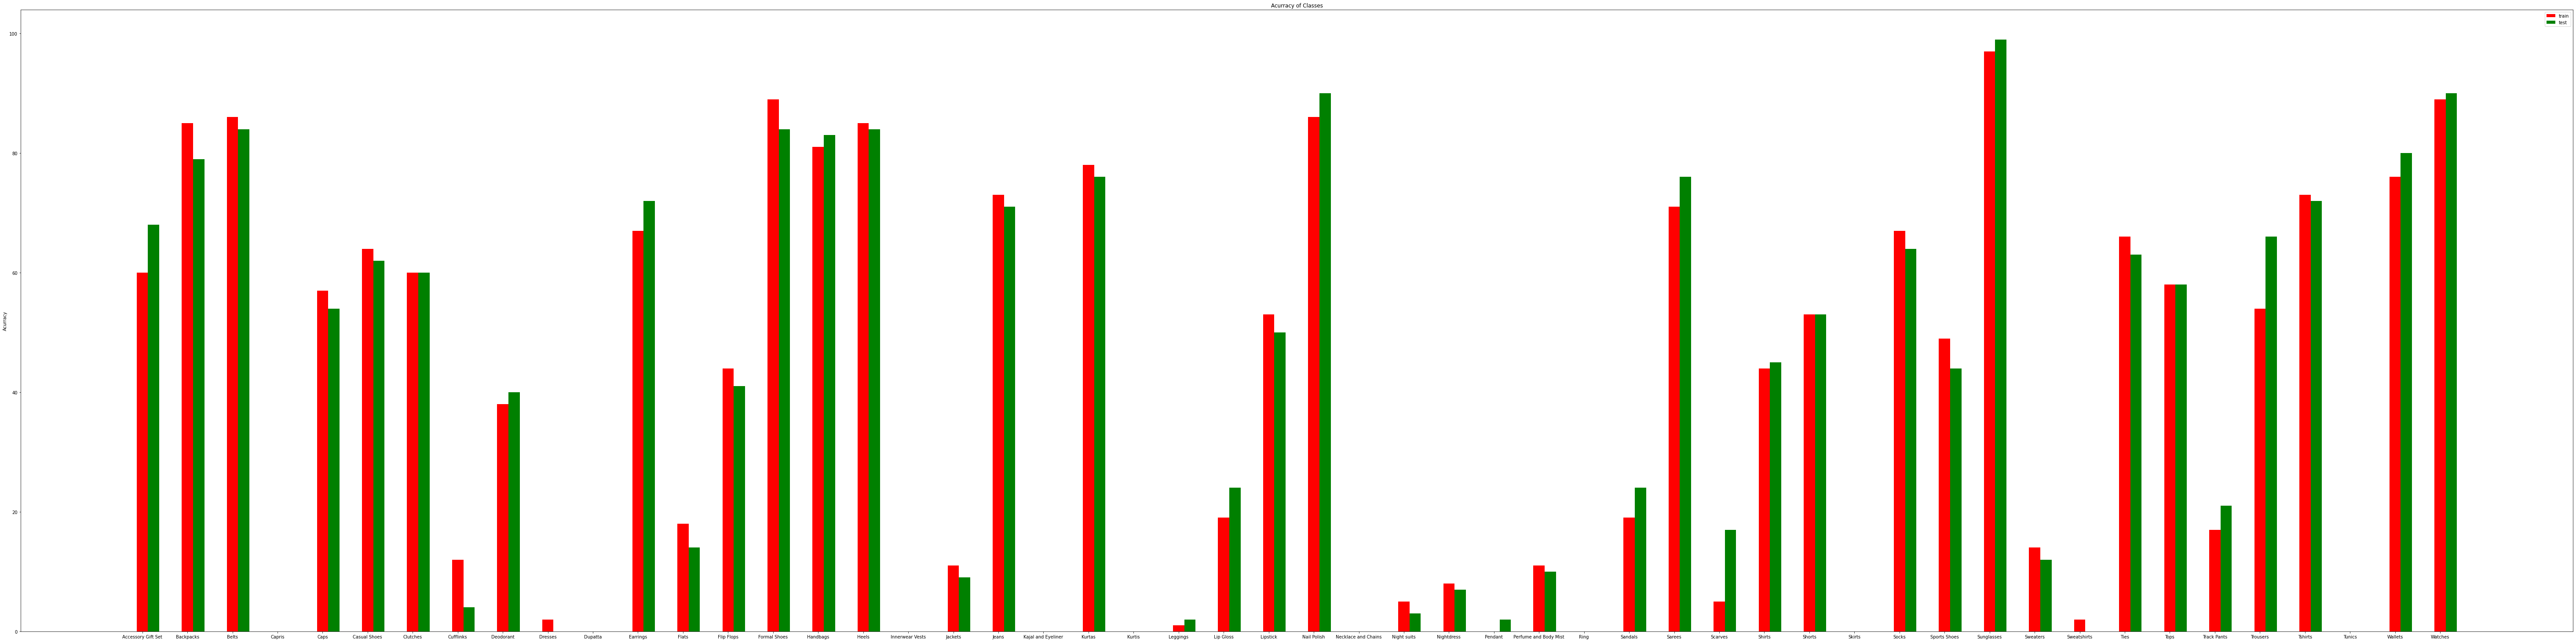

In [28]:

X = np.arange(len(classes1))
print(X)
fig = plt.figure(figsize=(len(classes1)*2, len(classes1) / 2))

plt.bar(X + 0.00, train_classes_acc2, color = 'r', width = 0.25 ,label='train')
plt.bar(X + 0.25, test_classes_acc2, color = 'g', width = 0.25, label='test')


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Acurracy')
plt.title('Acurracy of Classes')
plt.xticks(X, classes1)
plt.legend()
plt.show()

[2.6926134788938856, 2.0762122061119572, 1.7631060414559852, 1.5898897069718194, 1.4912210958710044, 1.4168031919156021, 1.357452153647918, 1.3022337552048107, 1.2675237053197852, 1.2258818799334024]


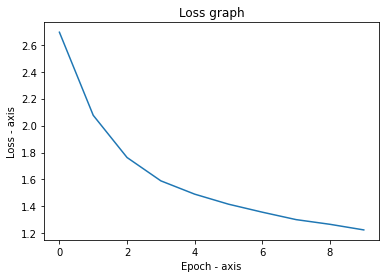

In [29]:
epoch = 10
epoch_list = list(range(epoch))
print(loss_array2)
plt.plot(epoch_list, loss_array2) 
plt.xlabel('Epoch - axis') 
plt.ylabel('Loss - axis') 
plt.title('Loss graph') 
plt.show() 

In [30]:
model_parameter(model)

+---------------+----------+
|   Parmeters   |  Values  |
+---------------+----------+
| layer1.weight | 23040000 |
|  layer1.bias  |   4800   |
| layer2.weight | 28800000 |
|  layer2.bias  |   6000   |
| layer3.weight | 45000000 |
|  layer3.bias  |   7500   |
| layer4.weight | 22500000 |
|  layer4.bias  |   3000   |
| layer5.weight | 5760000  |
|  layer5.bias  |   1920   |
| layer6.weight |  384000  |
|  layer6.bias  |   200    |
| layer7.weight |  10400   |
|  layer7.bias  |    52    |
+---------------+----------+
Total Train Variables = 125517872
